In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = r'/content/drive/MyDrive/Colab Notebooks/article/articles.csv'


Splitting data Successful

RandomForest Classifier Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90       499
           1       1.00      1.00      1.00       475
           2       1.00      1.00      1.00       494
           3       0.92      0.88      0.90       507
           4       1.00      1.00      1.00       494
           5       1.00      1.00      1.00       506
           6       1.00      1.00      1.00       483

    accuracy                           0.97      3458
   macro avg       0.97      0.97      0.97      3458
weighted avg       0.97      0.97      0.97      3458


RandomForest Accuracy Score:  0.9705031810294968

Confusion Matrix: 


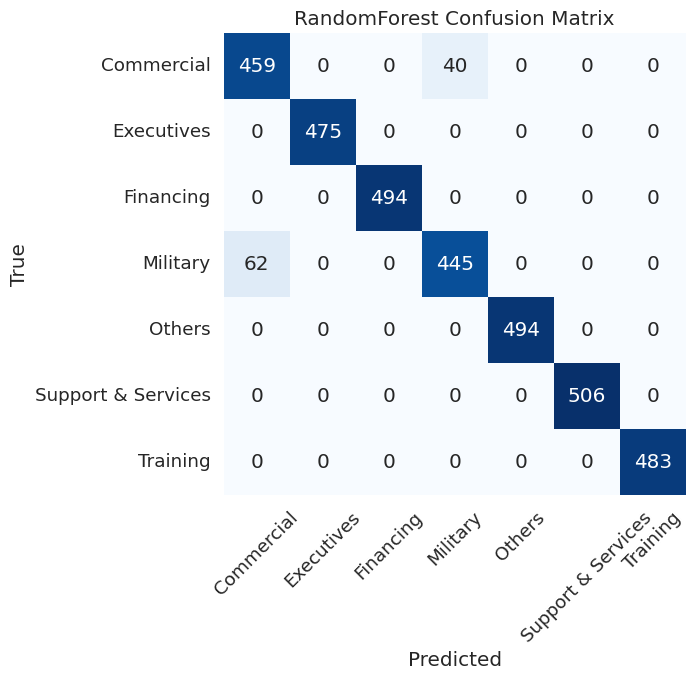


SVM Classifier Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.82       499
           1       0.99      0.99      0.99       475
           2       1.00      1.00      1.00       494
           3       0.88      0.85      0.87       507
           4       0.91      0.98      0.95       494
           5       0.98      1.00      0.99       506
           6       1.00      1.00      1.00       483

    accuracy                           0.94      3458
   macro avg       0.94      0.94      0.94      3458
weighted avg       0.94      0.94      0.94      3458


SVM Accuracy Score:  0.9441873915558127

Confusion Matrix: 


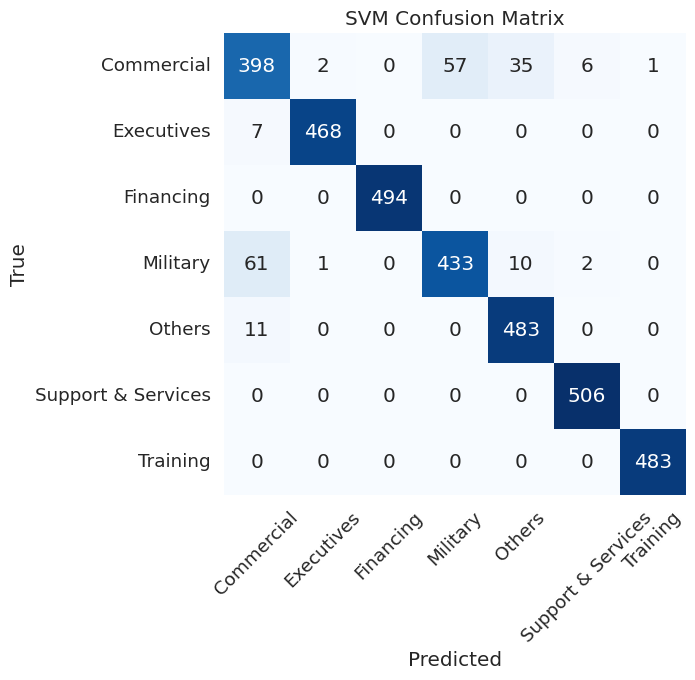

Model saved to /content/drive/MyDrive/Colab Notebooks/article/rf.pkl
Model loaded from /content/drive/MyDrive/Colab Notebooks/article/rf.pkl


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from gensim.models import KeyedVectors
import gensim.downloader as api
import re
import pickle

def load_data(file_path):
    df = pd.read_csv(file_path, encoding='latin1')
    df = df[['Full_Article', 'Article_Type']]
    df = df.dropna()
    return df

def clean_text(text):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', cleantext)
    return clean_text.strip()

def preprocess_data(df):
    df['Full_Article'] = df['Full_Article'].apply(lambda x: clean_text(x))
    return df

def encode_labels(df):
    label_encoder = LabelEncoder()
    df['Article_Type'] = label_encoder.fit_transform(df['Article_Type'])
    label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
    return df, label_encoder, label_mapping

def balance_data(X, y):
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled['Article_Type'] = y_resampled
    return df_resampled

def get_sentence_embeddings(data_texts, word_vectors):
    embeddings = []
    for text in data_texts:
        words = text.lower().split()
        vectors = [word_vectors[word] for word in words if word in word_vectors]
        if vectors:
            avg_vector = np.mean(vectors, axis=0)
        else:
            avg_vector = np.zeros(word_vectors.vector_size)
        embeddings.append(avg_vector)
    return np.array(embeddings)

def train_and_evaluate_model(clf, train_embeddings, train_labels, test_embeddings, test_labels, label_mapping, model_name):
    clf.fit(train_embeddings, train_labels)
    predicted_labels = clf.predict(test_embeddings)

    print(f"\n{model_name} Classifier Report:\n", classification_report(test_labels, predicted_labels))
    print(f"\n{model_name} Accuracy Score: ", accuracy_score(test_labels, predicted_labels))

    print(f"\nConfusion Matrix: ")
    confusion = confusion_matrix(test_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')

    # Add category labels
    tick_labels = [label_mapping[i] for i in range(len(label_mapping))]
    plt.xticks(ticks=np.arange(len(label_mapping))+0.5, labels=tick_labels, rotation=45)
    plt.yticks(ticks=np.arange(len(label_mapping))+0.5, labels=tick_labels, rotation=0)

    plt.show()

    return clf

def save_model(clf, file_path):
    with open(file_path, 'wb') as model_file:
        pickle.dump(clf, model_file)
    print(f"Model saved to {file_path}")

def load_model(file_path):
    with open(file_path, 'rb') as model_file:
        clf = pickle.load(model_file)
    print(f"Model loaded from {file_path}")
    return clf

if __name__ == "__main__":
    # Load and preprocess data
    file_path = '/content/drive/MyDrive/Colab Notebooks/article/articles.csv'
    df = load_data(file_path)
    df = preprocess_data(df)
    df, label_encoder, label_mapping = encode_labels(df)

    # Balance data
    X = df.drop('Article_Type', axis=1)
    y = df['Article_Type']
    df_resampled = balance_data(X, y)

    # Prepare data for embeddings
    data_texts = df_resampled['Full_Article'].to_list()
    data_labels = df_resampled['Article_Type'].to_list()

    # Load Word2Vec model
    word_vectors = api.load('word2vec-google-news-300')
    embeddings = get_sentence_embeddings(data_texts, word_vectors)

    # Split data into training and test sets
    train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, data_labels, test_size=0.2, random_state=42)
    print("\nSplitting data Successful")

    # Train and evaluate RandomForest model
    clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_rf = train_and_evaluate_model(clf_rf, train_embeddings, train_labels, test_embeddings, test_labels, label_mapping, "RandomForest")

    # Train and evaluate SVM model
    clf_svm = SVC(kernel='linear', random_state=42)
    clf_svm = train_and_evaluate_model(clf_svm, train_embeddings, train_labels, test_embeddings, test_labels, label_mapping, "SVM")

     # Save and load RandomForest model
    model_filename_rf = '/content/drive/MyDrive/Colab Notebooks/article/rf.pkl'
    save_model(clf_rf, model_filename_rf)
    loaded_clf_rf = load_model(model_filename_rf)
